# Elektri hinna ennustamine kasutades teeki `XGBoost`

[`XGBoost`](xgboost.readthedocs.io)
on teek, mis ilplementeerib Extreme Gradient Boosting algoritmi.

**Teegid**

In [5]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.


In [9]:
# arvutamine ja joonistamine
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# aegridade spetsiifiline
from xgboost import XGBRegressor


**Andmed ja puhastamine**

In [10]:
# laen treening- ja testandmed
data_raw =  pd.read_csv('./data/df_clean.csv')
test_raw = pd.read_csv('./data/df_clean_test.csv')

In [11]:
data_raw.head()

,Unnamed: 0,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,...,datetime,year,month,day,weekday,hour,date,is_holiday,season,google_trends_electricity
0,0,2021-09-01 00:00:00+03:00,11.2,10.3,94.0,0.0,0.0,320.0,7.2,16.7,...,2021-09-01 00:00:00,2021,9,1,2,0,2021-09-01,False,Autumn,5
1,1,2021-09-01 01:00:00+03:00,10.7,9.6,93.0,0.0,0.0,320.0,7.2,13.0,...,2021-09-01 01:00:00,2021,9,1,2,1,2021-09-01,False,Autumn,5
2,2,2021-09-01 02:00:00+03:00,9.9,9.0,94.0,0.0,0.0,320.0,7.2,13.0,...,2021-09-01 02:00:00,2021,9,1,2,2,2021-09-01,False,Autumn,5
3,3,2021-09-01 03:00:00+03:00,10.0,8.4,90.0,0.0,0.0,330.0,7.2,13.0,...,2021-09-01 03:00:00,2021,9,1,2,3,2021-09-01,False,Autumn,5
4,4,2021-09-01 04:00:00+03:00,9.0,8.1,94.0,0.0,0.0,300.0,3.6,13.0,...,2021-09-01 04:00:00,2021,9,1,2,4,2021-09-01,False,Autumn,5


In [12]:
data = data_raw.set_index(pd.to_datetime(data_raw['timestamp']))[["consumption"]]
data = data[~data.index.duplicated()].asfreq("H").sort_index()

test = test_raw.set_index(pd.to_datetime(test_raw['timestamp']))[[]]
test = test[~test.index.duplicated()].asfreq("H").sort_index()
test = test.tz_localize("+03:00")

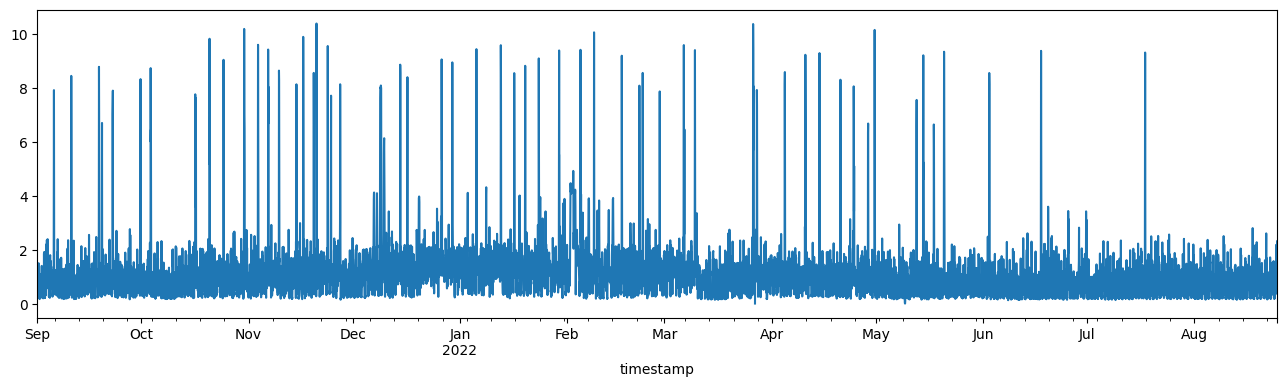

In [17]:
fig, ax=plt.subplots(figsize=(16, 4))
data["consumption"].plot()
plt.show()

In [26]:
data
relevant_data = data[(data.index.month > 4) | (data.index.month < 9)]
relevant_data

,consumption
timestamp,
2021-09-01 00:00:00,0.577
2021-09-01 01:00:00,0.594
2021-09-01 02:00:00,0.685
2021-09-01 03:00:00,1.016
2021-09-01 04:00:00,0.677
...,...
2022-08-24 19:00:00,0.678
2022-08-24 20:00:00,0.457
2022-08-24 21:00:00,0.500


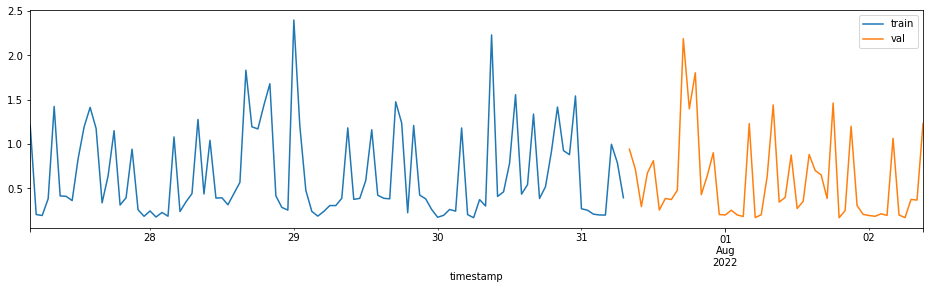

In [14]:
fig, ax=plt.subplots(figsize=(16, 4))
train["consumption"].plot(ax=ax, label="train")
val["consumption"].plot(ax=ax, label="val")
plt.legend()
plt.show()

In [44]:
def series_to_slicing_window(data, n_in=1, n_out=1):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

In [ ]:
 # transform list into array
 train_data = series_to_slicing_window(relevant_data, 10)
 # split into input and output columns
 trainX, trainy = train_data[:, :-1], train_data[:, -1]
 trainX, trainy
 # fit model
 model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
 model.fit(trainX, trainy)

In [37]:

prediction_data = list(trainX[-1])
prediction_data.pop(0)
prediction_data.append(trainy[0])

predictions = []


for _ in range(168):
    predictions.append(model.predict([prediction_data])[0])
    prediction_data.pop(0)
    prediction_data.append(predictions[-1])
predictions

[1.1956441,
 0.8739955,
 0.59938985,
 1.1623585,
 0.83665407,
 0.78062826,
 0.9422577,
 1.3015908,
 0.9869621,
 1.6670483,
 1.1269507,
 1.1582315,
 1.3750875,
 0.81379455,
 1.2424215,
 0.9046252,
 0.72804314,
 0.85627365,
 1.0389673,
 0.9695289,
 0.9662493,
 0.9561999,
 1.1899062,
 0.9280476,
 1.2133763,
 0.96452755,
 1.0294635,
 1.1534129,
 0.8856555,
 0.7479723,
 0.87121034,
 0.6120512,
 0.6093973,
 0.93842155,
 0.695543,
 0.80938226,
 1.004723,
 1.1568358,
 0.87650526,
 0.8449281,
 0.76162076,
 0.78856796,
 1.3148338,
 0.9770337,
 1.0667173,
 1.3463036,
 1.1911173,
 0.803547,
 1.1919357,
 1.1965278,
 0.7278447,
 0.8808343,
 0.64618814,
 1.0197953,
 1.2843914,
 0.8604676,
 0.829112,
 1.0164527,
 1.171716,
 0.9666959,
 0.8976077,
 1.0852784,
 1.2012556,
 1.0884898,
 0.82889676,
 1.0167253,
 0.77522504,
 0.87301254,
 1.1464044,
 1.0766277,
 1.4502821,
 1.319706,
 0.8512746,
 1.0072012,
 0.7793746,
 0.53903556,
 1.1275562,
 0.6279822,
 0.8683605,
 0.68609643,
 0.73766214,
 0.99413097,
 

In [42]:
# Add predictions to a submission file
submission = pd.read_csv("data/sample_submission.csv")
submission['consumption'] = predictions
submission.to_csv("submissions/xgboost-submission-iterative.csv", index=False)